In [1]:
# import numpy as np
# import os
# import pandas as pd
# import xarray as xr
# import rioxarray
# from matplotlib import pyplot as plt
# import seaborn as sns
import codebase
from codebase import ml_pipeline

In [2]:
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

- upstream of Lake Powell (San Juan River trib): 4152600
- Lee's Ferry: 4152450
- below Hoover Dam: 4152103
- US-Mexico border: 4152050

In [3]:
input_combos = [('Powell', 'glen canyon', 4152600),
                ('Powell', 'glen canyon', 4152450),
                ('Mead', 'hoover', 4152103),
                ('Mead', 'hoover', 4152050)]

In [4]:
res_name , dam_name, grdc_id = input_combos[1]

n_epochs = 300

In [5]:
all_data = ml_pipeline.LSTM_preprocessing(res_name = res_name,
                                          dam_name = dam_name,
                                          grdc_id = 4152103)

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/ann_scheliga/.conda/envs/rio_keras/share/proj failed


Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area


In [6]:
X_train, X_test, y_train, y_test = ml_pipeline.split_data_and_reshape(all_data)
X_met_train, X_met_test =ml_pipeline.met_split(X_train, X_test)

X train shape: (1, 910, 3); y train shape: (1, 910, 1)
X test shape: (1, 910, 3); y test shape: (1, 910, 1)


In [7]:
n_timesteps_in = X_train.shape[-2]
n_features = X_train.shape[-1]
n_timesteps_out = 1

In [8]:
model_nw = ml_pipeline.make_LSTM_model(n_timesteps_in,2)
model_nw_history = model_nw.fit(X_met_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_met_test, y_test))

2024-12-07 10:12:41.654150: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 910, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,810 (1.56 MB)

 Trainable params: 409,810 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - MeanAbsoluteError: 351.3388 - loss: 136569.9062 - val_MeanAbsoluteError: 239.6630 - val_loss: 59520.0625
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - MeanAbsoluteError: 351.2975 - loss: 136540.6719 - val_MeanAbsoluteError: 239.6107 - val_loss: 59494.9375
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - MeanAbsoluteError: 351.2454 - loss: 136503.9531 - val_MeanAbsoluteError: 239.5497 - val_loss: 59465.6992
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 351.1846 - loss: 136461.1875 - val_MeanAbsoluteError: 239.4819 - val_loss: 59433.2148
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - MeanAbsoluteError: 351.3829 - loss: 136601.1719 - val_MeanAbsoluteError: 239.4211 - val_loss: 59404.1016
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 351.0562 - loss: 136370.7812 - val_MeanAbsoluteError: 239.3535 - val_loss: 59371.6953
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAb

In [9]:
model_sw = ml_pipeline.make_LSTM_model(n_timesteps_in, 3)
model_sw_history = model_sw.fit(X_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_test, y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150)            │        92,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 910, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,410 (1.57 MB)

 Trainable params: 410,410 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - MeanAbsoluteError: 351.3500 - loss: 136578.3125 - val_MeanAbsoluteError: 239.7045 - val_loss: 59539.9062
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - MeanAbsoluteError: 351.3419 - loss: 136571.2656 - val_MeanAbsoluteError: 239.6909 - val_loss: 59533.3945
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - MeanAbsoluteError: 351.3214 - loss: 136556.7500 - val_MeanAbsoluteError: 239.6663 - val_loss: 59521.6367
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 351.2704 - loss: 136522.2188 - val_MeanAbsoluteError: 239.6385 - val_loss: 59508.4141
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - MeanAbsoluteError: 351.2517 - loss: 136507.3438 - val_MeanAbsoluteError: 239.5923 - val_loss: 59486.3516
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - MeanAbsoluteError: 351.2039 - loss: 136473.5938 - val_MeanAbsoluteError: 239.5284 - val_loss: 59455.9961
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - Mea

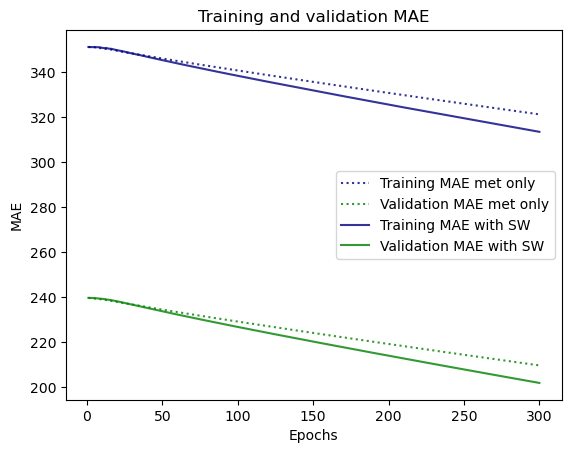

In [10]:
ml_pipeline.compare_epoch_error(model_nw_history.history,model_sw_history.history,fig_name='Mead_using_Powell_MAE')

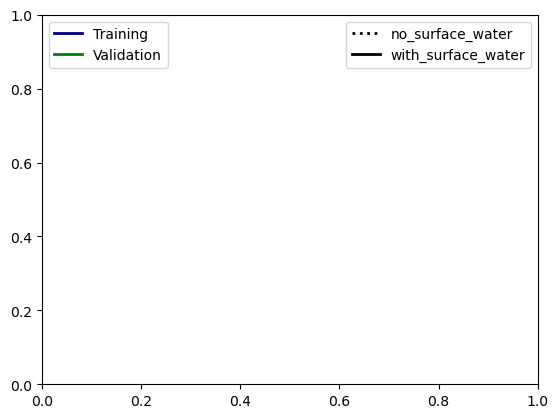

In [27]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

color_lines = [Line2D([0], [0], color='navy', lw=2),
                Line2D([0], [0], color='green', lw=2)]
style_lines = [Line2D([0], [0], color='black',linestyle=':', lw=2),
                Line2D([0], [0], color='black',linestyle='-', lw=2)]
fig, ax = plt.subplots()
color_legend = plt.legend(color_lines, ['Training', 'Validation'],loc='upper left')
ax.legend(style_lines, ['no_surface_water', 'with_surface_water'],loc='upper right')
plt.gca().add_artist(color_legend)